In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
np.random.seed(42)

In [ ]:
color_dir = '/content/drive/MyDrive/SAR/gan/v_2/agri/s2/'
gray_dir = '/content/drive/MyDrive/SAR/gan/v_2/agri/s1/'

In [ ]:
SIZE = 256
HEIGHT = SIZE
WIDTH = SIZE
ImagePath = color_dir
# N = 500

def ExtractInput(path):
    X_img = []
    y_img = []
    # for imageDir in os.listdir(ImagePath)[:N]:
    for imageDir in os.listdir(ImagePath):
        try:
            img = cv2.imread(os.path.join(ImagePath, imageDir))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

            img = img.astype(np.float32)
            img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
            #Convert the rgb values of the input image to the range of 0 to 1
            #1.0/255 indicates that we are using a 24-bit RGB color space.
            #It means that we are using numbers between 0–255 for each color channel
            #img_lab = 1.0/225*img_lab
            # resize the lightness channel to network input size
            img_lab_rs = cv2.resize(img_lab, (WIDTH, HEIGHT)) # resize image to network input size
            img_l = img_lab_rs[:,:,0] # pull out L channel
            #img_l -= 50 # subtract 50 for mean-centering
            img_ab = img_lab_rs[:,:,1:]#Extracting the ab channel
            img_ab = img_ab/128
            #The true color values range between -128 and 128. This is the default interval
            #in the Lab color space. By dividing them by 128, they too fall within the -1 to 1 interval.
            X_img.append(img_l)
            y_img.append(img_ab)
        except:
            pass
    X_img = np.array(X_img)
    y_img = np.array(y_img)

    return X_img,y_img

In [ ]:
X_, y_ = ExtractInput(ImagePath)

In [ ]:
from keras.layers import Conv2D,MaxPooling2D,UpSampling2D,Input,BatchNormalization,LeakyReLU,concatenate
from keras.models import Model

def InstantiateModel(in_):
    model_ = Conv2D(16,(3,3),padding='same',strides=1)(in_)
    model_ = LeakyReLU()(model_)
    #model_ = Conv2D(64,(3,3), activation='relu',strides=1)(model_)
    model_ = Conv2D(32,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)

    model_ = Conv2D(64,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)

    model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2D(256,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)

    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)

    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(64,(3,3), padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    #model_ = BatchNormalization()(model_)

    concat_ = concatenate([model_, in_])

    model_ = Conv2D(64,(3,3), padding='same',strides=1)(concat_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2D(32,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    #model_ = BatchNormalization()(model_)

    model_ = Conv2D(2,(3,3), activation='tanh',padding='same',strides=1)(model_)

    return model_

In [ ]:
Input_Sample = Input(shape=(HEIGHT, WIDTH,1))
Output_ = InstantiateModel(Input_Sample)
Model_Colourization = Model(inputs=Input_Sample, outputs=Output_)

In [ ]:
from keras.optimizers import Adam

LEARNING_RATE = 0.001
Model_Colourization.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                            loss='mean_squared_error')
Model_Colourization.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 16)   │            160 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 256, 256, 16)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 32)   │          4,640 │ leaky_re_lu[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 256, 256, 32)   │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 32)   │            128 │ leaky_re_lu_1[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 32)   │              0 │ batch_normalization[0… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 128, 128, 64)   │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 64)   │            256 │ leaky_re_lu_2[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 64)     │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 128)    │            512 │ leaky_re_lu_3[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_4 (LeakyReLU) │ (None, 64, 64, 256)    │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 64, 64, 256)    │          1,024 │ leaky_re_lu_4[0][0]    │
│ (BatchNormalization) 

 Total params: 820,386 (3.13 MB)

 Trainable params: 819,042 (3.12 MB)

 Non-trainable params: 1,344 (5.25 KB)

In [ ]:
def GenerateInputs(X_,y_):
    for i in range(len(X_)):
        X_input = X_[i].reshape(1,SIZE,SIZE,1)
        y_input = y_[i].reshape(1,SIZE,SIZE,2)
        yield (X_input,y_input)

from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val = train_test_split(X_,y_, random_state=42)

Model_Colourization.fit(
    GenerateInputs(X_, y_),
    epochs=50,
    verbose=1,
    steps_per_epoch=38,
    validation_data=GenerateInputs(X_val, y_val),
    validation_steps=10
)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - loss: 0.1321 - val_loss: 0.9233
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0236 - val_loss: 0.3053
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0084 - val_loss: 0.0961
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0086 - val_loss: 0.2668
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0090 - val_loss: 0.0977
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0086 - val_loss: 0.0775
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0052 - val_loss: 0.0740
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0035 - val_loss: 0.0438
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0022 - val_loss: 0.0569
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0016 - val_loss: 0.0348
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 6.0159e-04 - val_loss: 0.0224
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss

In [ ]:
Model_Colourization.save('/content/drive/MyDrive/SAR/models/colorization-CNN-agri.keras')

In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model('/content/drive/MyDrive/SAR/models/colorization-CNN-agri.keras')

In [ ]:
import cv2
import numpy as np

In [ ]:
WIDTH = 256
HEIGHT = 256
def ExtractTestInput(ImagePath):
    img = cv2.imread(ImagePath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_ = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img_ = cv2.cvtColor(img_, cv2.COLOR_RGB2Lab)
    img_=img_.astype(np.float32)
    img_lab_rs = cv2.resize(img_, (WIDTH, HEIGHT)) # resize image to network input size
    img_l = img_lab_rs[:,:,0] # pull out L channel
    #img_l -= 50
    img_l_reshaped = img_l.reshape(1,256,256,1)

    return img_l_reshaped

In [ ]:
img_path = '/content/drive/MyDrive/SAR/image.png'

In [ ]:
image_for_test = ExtractTestInput(img_path)
prediction = model.predict(image_for_test)
prediction = prediction*128
prediction = prediction.reshape(256,256,2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


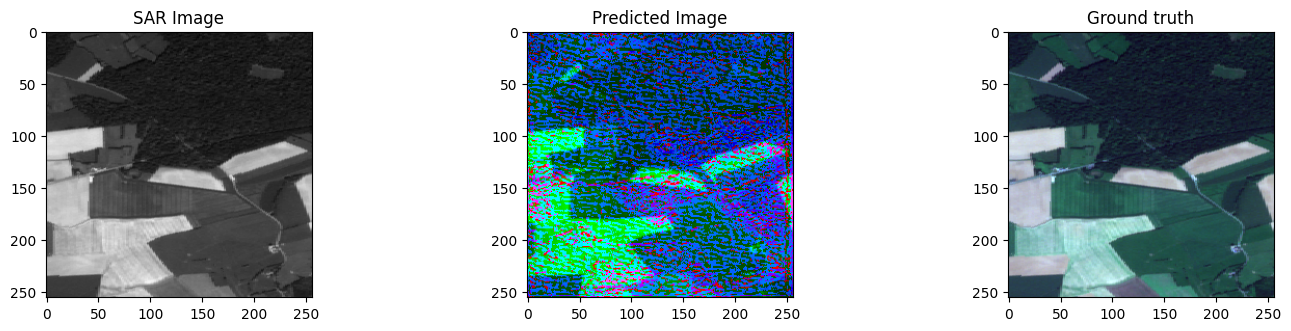

In [ ]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread('/content/drive/MyDrive/SAR/image-truth.png')
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (256, 256))
plt.title("SAR Image")
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = prediction
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
plt.imshow(img_1)

In [ ]:
prediction = np.concatenate([prediction, np.zeros((256, 256, 1))], axis=-1)

In [ ]:
img_1 = tf.convert_to_tensor(img_1, dtype=tf.float32)
prediction = tf.convert_to_tensor(prediction, dtype=tf.float32)

In [ ]:
psnr_value = tf.image.psnr(img_1, prediction, max_val=255.0)
print("PSNR (RGB vs. 3-Channel Prediction):", psnr_value.numpy())

PSNR (RGB vs. 3-Channel Prediction): 8.126369


In [ ]:
ssim_value = tf.image.ssim(img_1, prediction, max_val=255.0)
print("SSIM (RGB vs. 3-Channel Prediction):", ssim_value.numpy())

SSIM (RGB vs. 3-Channel Prediction): 0.0438325


In [ ]:
def compute_enl(image):
    # Ensure tensor format
    image = tf.convert_to_tensor(image, dtype=tf.float32)

    # Compute mean and standard deviation
    mean = tf.reduce_mean(image)
    std = tf.math.reduce_std(image)

    # Compute ENL (avoid division by zero)
    enl = (mean ** 2) / (std ** 2 + 1e-8)  # Adding small value to avoid division by zero

    return enl.numpy()

img_1_gray = tf.image.rgb_to_grayscale(tf.convert_to_tensor(img_1, dtype=tf.float32))
prediction_gray = tf.expand_dims(prediction[..., 0], axis=-1)
image_for_test_gray = tf.squeeze(image_for_test, axis=0)

enl_img_1 = compute_enl(img_1_gray)
enl_prediction = compute_enl(prediction_gray)
enl_test = compute_enl(image_for_test_gray)

print("ENL (img_1, Grayscale):", enl_img_1)
print("ENL (Prediction, First Channel):", enl_prediction)
print("ENL (Image for Test, Grayscale):", enl_test)

ENL (img_1, Grayscale): 1.7484661
ENL (Prediction, First Channel): 0.50310767
ENL (Image for Test, Grayscale): 4.796968


In [ ]:
import tensorflow as tf
import numpy as np

def compute_mse(image1, image2):
    # Ensure tensor format
    image1 = tf.convert_to_tensor(image1, dtype=tf.float32)
    image2 = tf.convert_to_tensor(image2, dtype=tf.float32)

    # Compute MSE
    mse = tf.reduce_mean(tf.math.squared_difference(image1, image2))
    return mse.numpy()

mse_value = compute_mse(img_1, prediction)
print("MSE (RGB vs. 3-Channel Prediction):", mse_value)

MSE (RGB vs. 3-Channel Prediction): 10010.218


In [ ]:
import lpips
import torch
import numpy as np

# Initialize LPIPS model (VGG-based)
lpips_model = lpips.LPIPS(net='vgg')

def compute_lpips_torch(image1, image2):
    # Convert to Tensor and normalize to [-1, 1]
    image1 = torch.tensor(image1.numpy()).permute(2, 0, 1).unsqueeze(0) / 127.5 - 1.0
    image2 = torch.tensor(image2.numpy()).permute(2, 0, 1).unsqueeze(0) / 127.5 - 1.0

    # Compute LPIPS
    lpips_distance = lpips_model(image1, image2)

    return lpips_distance.item()

# Compute LPIPS using PyTorch
lpips_value_torch = compute_lpips_torch(img_1, prediction)
print("LPIPS (PyTorch):", lpips_value_torch)


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/vgg.pth
LPIPS (PyTorch): 0.7746152877807617


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

# Load InceptionV3 model (pretrained on ImageNet)
inception_model = InceptionV3(weights="imagenet", include_top=True)

def compute_inception_score(images, splits=10):
    """
    Computes the Inception Score (IS) for a batch of images using Keras's InceptionV3.
    The images should be a numpy array of shape (N, 299, 299, 3) with values in [0, 255].
    """
    # Convert images to float32 tensor
    images = tf.convert_to_tensor(images, dtype=tf.float32)
    # Resize images to (299, 299)
    images = tf.image.resize(images, (299, 299)).numpy()
    # Preprocess images for InceptionV3 (this normalizes images to [-1, 1])
    images = preprocess_input(images)

    # Get predictions (logits) from InceptionV3
    logits = inception_model.predict(images)
    # Convert logits to probabilities using softmax
    p_y_given_x = tf.nn.softmax(logits).numpy()  # shape: (N, num_classes)

    # Compute Inception Score by splitting the data into 'splits' splits
    N = images.shape[0]
    split_size = N // splits
    split_scores = []

    for i in range(splits):
        # Get predictions for this split
        part = p_y_given_x[i * split_size: (i + 1) * split_size, :]
        # Compute the marginal probability p(y)
        p_y = np.mean(part, axis=0, keepdims=True)  # shape: (1, num_classes)
        # Compute the KL divergence for each image in the split
        kl_divs = np.sum(part * (np.log(part + 1e-16) - np.log(p_y + 1e-16)), axis=1)
        split_score = np.exp(np.mean(kl_divs))
        split_scores.append(split_score)

    return np.mean(split_scores)

# --- Example Usage ---

# Let's say you have a "prediction" array of shape (16, 256, 256, 2)
# First, convert it to 3 channels (InceptionV3 expects 3-channel RGB images)
def convert_2ch_to_3ch(image):
    # image: (256, 256, 2) --> (256, 256, 3) by padding with zeros for the third channel.
    return np.concatenate([image, np.zeros((image.shape[0], image.shape[1], 1))], axis=-1)

# For demonstration, create a simulated prediction array with 16 samples
num_samples = 16
# Simulate a prediction array with 2 channels and values in [0, 255]
# prediction = np.random.rand(num_samples, 256, 256, 2) * 255
# Convert each sample to 3 channels
prediction_3ch = np.array([convert_2ch_to_3ch(pred) for pred in prediction])

# Now compute the Inception Score for these images
is_score = compute_inception_score(prediction_3ch, splits=4)
print("Inception Score:", is_score)


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 3 dimension(s)